In [1]:
# !pip install git+https://github.com/crispitagorico/sigkernel.git
# !git clone 'https://github.com/ryanmccrickerd/rough_bergomi.git'

In [1]:
import numpy as np
import torch
from rbergomi import rBergomi, rBergomi_MC_pricer, rBergomi_sigkernel_pricer
from utils import r2, generate_evaluation_paths

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [123]:
n_samples_MC = 30000
n_increments = 20

m   = 200   # collocation points interior
n   = 200    # collocation points boundary
T   = 1.
a   = -0.4  
xi  = 0.055 
eta = 1.9
rho = -0.9

sigma_t      = 0.1
sigma_x      = 0.1
sigma_sig    = 10.
max_batch    = 20 
dyadic_order = 2

log_strike      = 2.  
mid_price       = 2.
payoff_eur_call = lambda x: max(np.exp(x) - np.exp(log_strike), 0.) 

n_eval       = 20
t_inds_eval  = np.random.choice(n_increments, n_eval)
xs_eval      = np.array(np.random.normal(loc=log_strike, scale=0.5, size=n_eval))
paths_eval   = generate_evaluation_paths(t_inds_eval, n_increments, T, a)

In [124]:
rb_mc_pricer        = rBergomi_MC_pricer(n_increments, n_samples_MC, T, a, xi, eta, rho)
rb_sigkernel_pricer = rBergomi_sigkernel_pricer(n_increments, mid_price, m, n, T, a, xi, eta, rho, 
                                                sigma_t, sigma_x, sigma_sig, dyadic_order, max_batch, device)

In [125]:
%%time
mc_prices = rb_mc_pricer.fit_predict(t_inds_eval, xs_eval, paths_eval, payoff_eur_call)

CPU times: user 4.53 s, sys: 44.3 ms, total: 4.57 s
Wall time: 4.51 s


In [126]:
rb_sigkernel_pricer.fit(payoff_eur_call)

In [127]:
%%time
sigkernel_prices = rb_sigkernel_pricer.predict(t_inds_eval, xs_eval, paths_eval) 

CPU times: user 468 ms, sys: 316 ms, total: 784 ms
Wall time: 307 ms


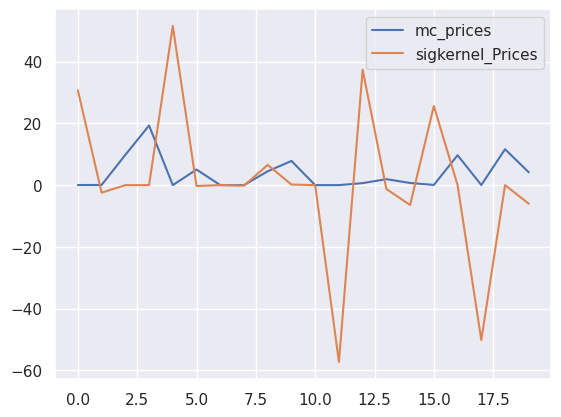

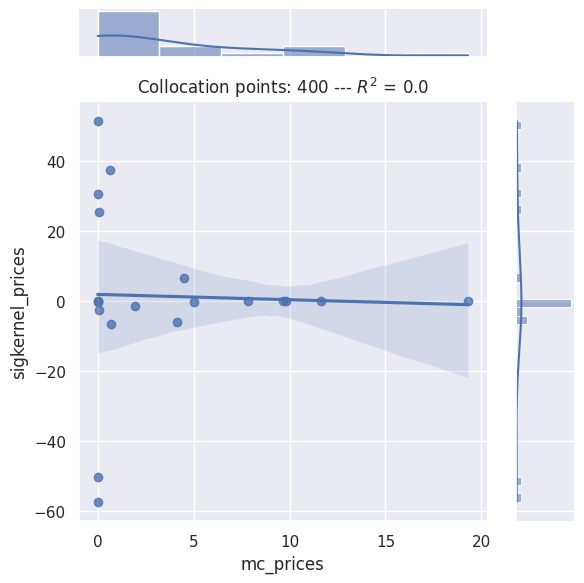

In [128]:
plt.plot(mc_prices, label='mc_prices')
plt.plot(sigkernel_prices, label='sigkernel_Prices')
plt.legend()
plt.show()

fig = sns.jointplot(x=mc_prices, y=sigkernel_prices, kind='reg')
fig.set_axis_labels('mc_prices', 'sigkernel_prices') 
plt.title(f"Collocation points: {m+n} --- $R^2$ = {np.round(r2(mc_prices, sigkernel_prices), 2)}")
plt.tight_layout()
plt.show()

In [ ]:
# # gradient descent parameters
# phi          = lambda x: max(x - np.exp(log_strike), 0.)  
# lr           = 1e-2
# n_iter       = 100
# print_every  = 5
# batch_size   = 100
# lambda_      = 0.5
# penalty      = 1e-5
# dt_scheduler = 50
# x_scheduler  = 0.5

In [8]:
# t_ind_try, t_try, x_try, T_try, K_try = generator(m, n_increments+1, T, mid_price, a, xi, eta, rho)
# fig, ax = plt.subplots(1, 2, figsize=(10,4))
# for j in range(N):
#     ax[0].plot(T_try[j,:,0], T_try[j,:,1], color='blue', alpha=0.1)
#     ax[1].plot(K_try[j,:,1], color='red', alpha=0.1)
# ax[0].set_title('Evaluation paths')
# ax[1].set_title('Directions')
# plt.show()

In [14]:
# eval_paths = generate_evaluation_paths(t_ind_try, n_increments, T, a)
# rb_sigkernel = rBergomi_sigkernel_pricer(n_increments, mid_price, m, n, T, a, xi, eta, rho, 
#                                          sigma_t, sigma_x, sigma_sig, max_batch, device)
# rb_sigkernel.fit(payoff_eur_call)
# directions = rb_sigkernel.directions
# fig, ax = plt.subplots(1, 2, figsize=(10,4))
# for j in range(m):
#     ax[0].plot(eval_paths[j,:,0], eval_paths[j,:,1], color='blue', alpha=0.1)
#     ax[1].plot(directions[j,:,1], color='red', alpha=0.1)
# ax[0].set_title('Evaluation paths')
# ax[1].set_title('Directions')
# plt.show()

In [3]:
# def exp_kernel(x, y, sigma):
#     return torch.exp(-(x-y)**2/(2.*sigma**2))

# def K(s, t, a):
#     return (s-t)**a

# def psi(t, x, a, xi, eta):
#     return xi*torch.exp(eta*np.sqrt(2*a+1)*x-(eta**2/2)*t**(2*a-1))

# def r2(x, y):
#     return scipy.stats.pearsonr(x, y)[0] ** 2

In [41]:
# def generator(n_samples, n_steps, T, x0, a, xi, eta, rho, random_state=None):

#     """Returns: 
#                 - idx: tensor of shape (n_samples,) of randomly chosen indices in {0,1,...,n_steps-1}
#                 - ts: tensor of shape (n_samples,) of time indices in [0,T]
#                 - xs: tensor of shape (n_samples,) of prices ~ N(x0, 1)
#                 - Ts: tensor of shape (n_samples, n_steps, 2) of time-augmented paths Theta^t with t in ts
#                 - Ks: tensor of shape (n_samples, n_steps, 2) of time-augmented paths K^t with t in ts
#     """

#     # set random state
#     np.random.seed(random_state)

#     # time steps
#     dt = T/n_steps

#     # time grid
#     t_grid = torch.linspace(0., T, n_steps)
    
#     # random time indices
#     idx = np.random.choice(np.arange(n_steps), n_samples)

#     # initialize arrays
#     ts = torch.zeros((n_samples,), dtype=torch.float64)
#     xs = torch.normal(mean=x0*torch.ones(n_samples), std=1).to(dtype=torch.float64)
#     Ts = torch.zeros((n_samples, n_steps, 2), dtype=torch.float64)
#     Ks = torch.zeros((n_samples, n_steps, 2), dtype=torch.float64)

#     # Generate sample paths
#     for i in range(n_samples):
        
#         # Brownian increments
#         dw = torch.normal(0., torch.sqrt(torch.tensor(dt)), size=(n_steps-1, ))

#         # cut-off point t0
#         i0 = idx[i]
#         t0 = i0*dt

#         # time samples
#         ts[i] = t0

#         # Theta^t
#         Ts[i,:,0] = t_grid
#         for j in range(i0, n_steps): 
#             t = j*dt
#             integral = 0.
#             for k in range(i0):
#                 r = k*dt
#                 integral += ((r-t)**a)*dw[k] 
#             Ts[i,j,1] = integral
        
#         # K^t
#         for j in range(i0+1, n_steps):
#             t = j*dt
#             Ks[i, j, 1] = (t - t0)**a

#     return idx, ts, xs, Ts, Ks 

In [5]:
# def L(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, batch_size, 
#       n_steps, T, x0, a, xi, eta, rho, phi, lambda_, penalty):
    
#     # nb of collocation points
#     n_cps = alphas.shape[0]
    
#     # generate samples
#     idx_batch, t_batch, x_batch, T_batch, K_batch = generator(batch_size, n_steps, T, x0, a, xi, eta, rho)
    
#     # compute first and second directional derivatives of sigkernel
#     ksig, ksig_diff, ksig_diffdiff = signature_kernel.compute_kernel_and_derivatives_Gram(T_batch.to(device), 
#                                                                                           T_cps.to(device), 
#                                                                                           K_batch.to(device))
            
#     losses = torch.zeros((batch_size,))
#     losses_T = torch.zeros((batch_size,))
#     for j in range(batch_size): 
        
#         # Sample t, x
#         ind = idx_batch[j]
#         t = t_batch[j]
#         x = x_batch[j]
#         wt = T_batch[j,ind,1]

#         loss = 0.
#         loss_T = 0.
#         for i in range(n_cps):
            
#             # select collocation points
#             ti = t_cps[i]
#             xi = x_cps[i]
                      
#             # factors appearing in loss
#             l_t = (t-ti)/(sigma_t**2) 
#             l_x = (x-xi)/(sigma_x**2) 
#             l_xx = (sigma_x**2 - (x-xi)**2)/(sigma_x**4)
#             e_t = exp_kernel(t, ti, sigma_t)
#             e_T = exp_kernel(T, ti, sigma_t)
#             e_x = exp_kernel(x, xi, sigma_x)
#             p = psi(t, wt, a, xi, eta)

#             # terms in loss
#             u_T  = e_T*e_x*ksig[j,i]
#             D_t  = -l_t*e_t*e_x*ksig[j,i]
#             D_x  = -l_x*e_t*e_x*ksig[j,i]
#             D_xx = -l_xx*e_t*e_x*ksig[j,i]
#             D_Kx = -l_x*e_t*e_x*ksig_diff[j,i]
#             D_KK = e_t*e_x*ksig_diffdiff[j,i]

#             # putting everything together
#             loss += alphas[i]*(D_t -0.5*(p**2)*D_x + 0.5*(p**2)*D_xx + 0.5*D_KK + rho*p*D_Kx)
#             loss_T += alphas[i]*u_T

#         losses[j] = loss**2
#         losses_T[j] = (loss_T - phi(x))**2

#     return lambda_*torch.mean(losses) + (1.-lambda_)*torch.mean(losses_T) + penalty*torch.sum(alphas**2)


# def evaluate(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, t_batch, x_batch, T_batch):
#     n_cps = alphas.shape[0]
#     batch_size = t_batch.shape[0]
#     out = torch.zeros((batch_size,))
#     for j in range(batch_size):
#         for i in range(n_cps):
#             e_t = exp_kernel(t_batch[j], t_cps[i], sigma_t)
#             e_x = exp_kernel(x_batch[j], x_cps[i], sigma_x)
#             ksig = signature_kernel.compute_kernel(T_batch[j].unsqueeze(0).to(device), T_cps[i].unsqueeze(0).to(device))[0]
#             out[j] = out[j] + alphas[i]*e_t*e_x*ksig
#     return out

In [26]:
# # collocation points
# _, t_cps, x_cps, T_cps, _ = generator(m+n, n_increments+1, T, mid_price, a, xi, eta, rho)

# # Specify the static kernel 
# static_kernel = sigkernel.RBFKernel(sigma=sigma_sig)

# # Initialize the corresponding signature kernel
# signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)

# # randomly initialize the trainable parameters
# alphas = torch.tensor(np.random.normal(size=m+n, scale=np.sqrt(1./m+n)), requires_grad=True)
# # alphas = torch.zeros((n_cps,), requires_grad=True)

# # for evaluation
# t_batch_eval = torch.tensor(n_eval*[0.], dtype=torch.float64)
# x_batch_eval = torch.tensor(xs_eval, dtype=torch.float64)
# T_batch_eval = torch.zeros((n_eval, n_increments+1, 2), dtype=torch.float64)
# T_batch_eval[:,:,0] = torch.linspace(0, 1, n_increments+1).to(dtype=torch.float64)

# # optimiser
# optimizer = torch.optim.Adam([alphas], lr=lr)

# # scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=dt_scheduler, gamma=x_scheduler)

# # store losses
# losses = []

In [42]:
# # training by gradient descent
# for i in range(n_iter):
    
#     optimizer.zero_grad()
    
#     # computing loss
#     loss = L(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, 
#              batch_size, n_increments+1, T, mid_price, a, xi, eta, rho, phi, lambda_, penalty) 
    
#     # storing the calculated loss
#     losses.append(loss.item())
    
#     # backward pass for computing the gradients of the loss w.r.t to learnable parameters
#     loss.backward()
    
#     # run optimiser
#     optimizer.step()
    
#     # run scheduler to decrease learning rate
#     scheduler.step()
        
#     # evaluation
#     if i % print_every == 0:
#         with torch.no_grad():
#             sigkernel_prices_old = evaluate(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, t_batch_eval, x_batch_eval, T_batch_eval)

#             # priting the values for understanding
#             print('iter: {}, call price: {:.2f}, loss: {:.3f}, learning rate: {:.6f} '.format(i, sigkernel_prices_old.mean().item(), loss.item(), scheduler.get_last_lr()[0]))

In [43]:
# plt.plot(losses)
# plt.show()